#README

Краткое описание нашего решения:
- Мы обрабатываем входные данные (сюда входят заполнение NaN, обработка фичей и приведение их  правильному формату, удаление не нужных фичей и т.п)
- На полученный данных обучаем две модели предсказываться в каком состоянии находится/будет находиться трактор : catboost и XGBoost (используеться реалезация от Яндекса), затем объединяем их в ансамбль
-Анализируем важность фичей с помощью различных библиотек
- 1 ступень. Добавляем алгоритму возможность находить отклонения признаковот нормы. Благодаря этому мы можем сделать предположения почему трактор находиться в данном состоянии (поломан, анамалии)
- 2 ступень. Создаем векторную бд, с помощью нее находим близость нашего измерения с другими измерениями, это позволяет предугадать будущее изменение состояния трактора
- Обработка логов. Здесь объеденяются все предидущие этапы (этот этап перенесен в Django-проект)

#Установка библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install catboost
!pip install shap
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ..

#Предобработка данных

##функции для предобработки данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
list_to_drop=['Дата и время','Нагрузка на двигатель, %', 'iButton2', 'Крутящий момент (spn513), Нм',
'Положение рейки ТНВД (spn51), %', 'Расход топлива (spn183), л/ч',
'ДВС. Температура наддувочного воздуха, °С',
'Давление наддувочного воздуха двигателя (spn106), кПа', 'Текущая передача (spn523)',
'Температура масла гидравлики (spn5536), С', 'Педаль слива (spn598)']

In [ ]:
def hours_minutes_to_minutes(hm):
    if isinstance(hm, str):
        h, m = hm.split(':')
        return int(h) * 60 + int(m)
    else:
        return hm

In [ ]:
def data_preprocess(data,list_to_drop, mode='Train'):
  print('Предобработка начата')
  df=data
  df.replace('        -', np.NaN, inplace=True)
  df.replace('-', np.NaN, inplace=True)
  df=df.drop(list_to_drop, axis=1)

  #df['Дата и время']=df['Дата и время'].astype('datetime64[ns]')

  df=df.replace(',', '.', regex=True)
  df=df.replace('Отпущ.', 0, regex=True)
  df=df.replace('Нажат.', 1, regex=True)
  df['Значение счетчика моточасов, час:мин'] = df['Значение счетчика моточасов, час:мин'].apply(hours_minutes_to_minutes)
  for column in df.columns:
    if column not in ["label", "Дата и время"]:
      df[column] = pd.to_numeric(df[column], errors='coerce')
  df_cleaned = df.dropna(how='all', subset=df.columns[:-1])

  df_cleaned.interpolate(method='linear', inplace=True)
  #for column in df_cleaned.columns:
  #  df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)

  #if mode=="Test": df=df.drop(['label'])
  df_cleaned.fillna(df_cleaned.median(), inplace=True)
  return df_cleaned

In [ ]:
def create_etalons(df):
  problem_df=df[df['label']=='Проблемный']
  normal_df=df[df['label']=='Нормальный']
  anomal_df=df[df['label']=='Аномальный']
  etalon_problem=pd.DataFrame({
    'mean': problem_df.mean(),
    'std': problem_df.std()})
  etalon_normal=pd.DataFrame({
      'mean': normal_df.mean(),
      'std': normal_df.std()})
  etalon_anomal=pd.DataFrame({
      'mean': anomal_df.mean(),
      'std': anomal_df.std()})

  etalon_problem['range_min']=etalon_problem['mean']-etalon_problem['std']
  etalon_problem['range_max']=etalon_problem['mean']+etalon_problem['std']

  etalon_normal['range_min']=etalon_normal['mean']-etalon_normal['std']
  etalon_normal['range_max']=etalon_normal['mean']+etalon_normal['std']

  etalon_anomal['range_min']=etalon_anomal['mean']-etalon_anomal['std']
  etalon_anomal['range_max']=etalon_anomal['mean']+etalon_anomal['std']

  return [etalon_problem, etalon_normal, etalon_anomal]


In [ ]:
import chromadb
def create_db(df):
  problem_df=df[df['label']=='Проблемный'].iloc[:2000]
  normal_df=df[df['label']=='Нормальный'].iloc[:2000]
  anomal_df=df[df['label']=='Аномальный'].iloc[:2000]

  df = pd.concat([problem_df, normal_df, anomal_df], axis=0, ignore_index=True).reset_index(drop=True)
  metadata_dict= df['label']
  df=df.drop('label', axis=1)

  good_df_arr=df.values.tolist()

  ids=[str(x) for x in range(len(good_df_arr))]
  metadata_dict.index = ids
  client = chromadb.PersistentClient(path="./")
  #print('good_df_arr:',good_df_arr.shape)

  try:
    client.delete_collection(name="all-my-documents")
  except:
    pass
  collection = client.create_collection("all-my-documents")
  metadata_dict=metadata_dict.to_dict()
  output_list = [{"label": l} for l in metadata_dict.values()]
  collection.add(
      embeddings=good_df_arr,
      ids=ids,
      metadatas=output_list
  )
  return collection

def get_simularity_samples(collection,rows_arr):
  rows_arr=rows_arr.values.tolist()

  #print('rows_arr:',rows_arr.shape)
  results = collection.query(
      query_embeddings=rows_arr,
      n_results=1,

  )
  return results




##загрузка данных

In [ ]:
anomal_df=pd.read_csv('/content/drive/MyDrive/хаки/EES/dataset._anomaly.csv', sep=";")
problem_df=pd.read_csv('/content/drive/MyDrive/хаки/EES/dataset._problems.csv', sep=";")
normal_df = pd.read_csv('/content/drive/MyDrive/хаки/EES/dataset._normal.csv', sep=";")

anomal_df=anomal_df.sample(100000)#iloc[:10000]
problem_df=problem_df.sample(100000)#.iloc[:10000]
normal_df=normal_df.sample(100000)#.iloc[:10000]


problem_df['label']='Проблемный'
normal_df['label']='Нормальный'
anomal_df['label']='Аномальный'

#Объеденение трех датасетов в один
df = pd.concat([problem_df, normal_df, anomal_df], axis=0, ignore_index=True).reset_index(drop=True)

del normal_df, problem_df, anomal_df

In [ ]:
df.sample(3)

,Дата и время,"Полож.пед.акселер.,%","Нагрузка на двигатель, %","Давл.масла двиг.,кПа","Темп.масла двиг.,°С","Обор.двиг.,об/мин","Значение счетчика моточасов, час:мин",Сост.пед.сцепл.,iButton2,КПП. Температура масла,...,Холодный старт (spn3871),"Крутящий момент (spn513), Нм","Положение рейки ТНВД (spn51), %","Расход топлива (spn183), л/ч","ДВС. Температура наддувочного воздуха, °С","Давление наддувочного воздуха двигателя (spn106), кПа",Текущая передача (spn523),"Температура масла гидравлики (spn5536), С",Педаль слива (spn598),label
186741,07/07/2023 16:55:46,"0,0",-,480,"-273,000","1900,750",577:12,Отпущ.,NaN,-273,...,-,-,-,-,-,-,-,-,-,Нормальный
202619,11/06/2023 17:18:02,"2,0",-,514,140,"3315,000",-,-,NaN,-217,...,-,-,-,-,-,-,-,-,-,Аномальный
112492,07/06/2023 00:25:52,"0,0",-,128,"-273,000","651,125",519:00,Отпущ.,NaN,-273,...,-,-,-,-,-,-,-,-,-,Нормальный


##Обработка данных

In [ ]:

df = data_preprocess(df,list_to_drop)

#Создание эталонов каждого класса для последующего сравнения с ними
etalon_problem, etalon_normal, etalon_anomal=create_etalons(df)
etalon_problem.to_csv("etalon_problem.csv")
etalon_normal.to_csv("etalon_normal.csv")
etalon_anomal.to_csv("etalon_anomal.csv")

Предобработка начата


In [ ]:
df.sample(3)

,"Полож.пед.акселер.,%","Давл.масла двиг.,кПа","Темп.масла двиг.,°С","Обор.двиг.,об/мин","Значение счетчика моточасов, час:мин",Сост.пед.сцепл.,КПП. Температура масла,КПП. Давление масла в системе смазки,Скорость,ДВС. Давление смазки,...,Неисправность тормозной системы (spn3863),Термостарт (spn3862),Разрешение запуска двигателя (spn3861),Низкий уровень ОЖ (spn3860),Аварийная температура масла ГТР (spn3867),Необходимость сервисного обслуживания (spn3866),Подогрев топливного фильтра (spn3865),Вода в топливе (spn3864),Холодный старт (spn3871),label
206386,19.0,1457.0,145.0,287.0,19650.0,0.0,-180.0,289.0,23.0,1336.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Аномальный
31337,0.0,528.0,-273.0,1893.0,101448.0,0.0,-273.0,1168.0,0.0,528.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Проблемный
20133,94.8,468.0,-273.0,1891.5,134544.8,0.0,-273.0,1248.0,10.3,468.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Проблемный


In [ ]:
df['label']=df['label'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252748 entries, 0 to 299999
Data columns (total 45 columns):
 #   Column                                                       Non-Null Count   Dtype   
---  ------                                                       --------------   -----   
 0   Полож.пед.акселер.,%                                         252748 non-null  float64 
 1   Давл.масла двиг.,кПа                                         252748 non-null  float64 
 2   Темп.масла двиг.,°С                                          252748 non-null  float64 
 3   Обор.двиг.,об/мин                                            252748 non-null  float64 
 4   Значение счетчика моточасов, час:мин                         252748 non-null  float64 
 5   Сост.пед.сцепл.                                              252748 non-null  float64 
 6   КПП. Температура масла                                       252748 non-null  float64 
 7   КПП. Давление масла в системе смазки                    

#Обучение моделей

В этоп пункте обучаются 2 модели, а затем объединяеться в ансабль

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df,test_size=0.2,random_state=42)

In [ ]:
cat_features=[]

In [ ]:
def preprocess_data_part(data_part):

    X = data_part.drop(['label'], axis=1)
    y = data_part['label']
    return X, y

X_train, y_train = preprocess_data_part(df_train)
X_val, y_val = preprocess_data_part(df_val)



In [ ]:
from catboost import Pool

train_pool = Pool(
    X_train, y_train,
    cat_features=cat_features,
)

validation_pool = Pool(
    X_val, y_val,
    cat_features=cat_features,
)


## Обучение catboost (SymmetricTree технология)

In [ ]:
from catboost import CatBoostClassifier

def fit_catboost_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        #class_weights=weights_dict,#list_of_weights,
        iterations=10000,
        learning_rate=0.05,
        loss_function="MultiClass",
        eval_metric='AUC',
        task_type='GPU',
        train_dir='train',
        early_stopping_rounds=500,
        grow_policy = "SymmetricTree",#"SymmetricTree" #Depthwise #Lossguide
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )

catboost_model = fit_catboost_model(train_pool, validation_pool)


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9936077	best: 0.9936077 (0)	total: 274ms	remaining: 45m 42s
500:	test: 0.9998789	best: 0.9998789 (500)	total: 21.7s	remaining: 6m 52s
1000:	test: 0.9999258	best: 0.9999258 (998)	total: 34.2s	remaining: 5m 7s
1500:	test: 0.9999415	best: 0.9999416 (1499)	total: 42.5s	remaining: 4m
2000:	test: 0.9999492	best: 0.9999492 (2000)	total: 1m	remaining: 4m 2s
2500:	test: 0.9999538	best: 0.9999539 (2497)	total: 1m 16s	remaining: 3m 48s
3000:	test: 0.9999567	best: 0.9999567 (2996)	total: 1m 23s	remaining: 3m 14s
3500:	test: 0.9999587	best: 0.9999587 (3500)	total: 1m 34s	remaining: 2m 55s
4000:	test: 0.9999606	best: 0.9999606 (3976)	total: 1m 45s	remaining: 2m 37s
4500:	test: 0.9999620	best: 0.9999620 (4500)	total: 1m 55s	remaining: 2m 20s
5000:	test: 0.9999625	best: 0.9999626 (4989)	total: 2m 2s	remaining: 2m 2s
5500:	test: 0.9999632	best: 0.9999632 (5500)	total: 2m 12s	remaining: 1m 48s
6000:	test: 0.9999636	best: 0.9999637 (5979)	total: 2m 29s	remaining: 1m 39s
6500:	test: 0.9999638	b

In [ ]:
catboost_model.save_model('catboost_model.bin')

##Обучение XGBoost (Depthwise технология)

Оригинальная библиотека XGBoost использует Depthwise подход для построения деревьев, так-что чтобы не импортировать библиотеку мы используем реализацию Depthwise от Яндекса (результат один и тот же)

In [ ]:
def fit_XGBoost_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        #class_weights=weights_dict,#list_of_weights,
        iterations=10000,
        learning_rate=0.05,
        loss_function="MultiClass",
        eval_metric='AUC',
        task_type='GPU',
        train_dir='train',
        early_stopping_rounds=500,
        grow_policy = "Depthwise",#"SymmetricTree" #Depthwise #Lossguide
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )

XGBoost_model = fit_XGBoost_model(train_pool, validation_pool)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9940119	best: 0.9940119 (0)	total: 14.9ms	remaining: 2m 29s
500:	test: 0.9999351	best: 0.9999351 (497)	total: 9.85s	remaining: 3m 6s
1000:	test: 0.9999542	best: 0.9999542 (1000)	total: 21.5s	remaining: 3m 13s
1500:	test: 0.9999598	best: 0.9999598 (1500)	total: 36.1s	remaining: 3m 24s
2000:	test: 0.9999628	best: 0.9999630 (1950)	total: 51.6s	remaining: 3m 26s
2500:	test: 0.9999641	best: 0.9999642 (2464)	total: 1m 7s	remaining: 3m 23s
3000:	test: 0.9999650	best: 0.9999651 (2993)	total: 1m 20s	remaining: 3m 7s
3500:	test: 0.9999655	best: 0.9999655 (3499)	total: 1m 37s	remaining: 3m
4000:	test: 0.9999661	best: 0.9999661 (3999)	total: 1m 47s	remaining: 2m 41s
4500:	test: 0.9999661	best: 0.9999661 (4410)	total: 2m 2s	remaining: 2m 30s
5000:	test: 0.9999663	best: 0.9999663 (4990)	total: 2m 13s	remaining: 2m 13s
5500:	test: 0.9999663	best: 0.9999664 (5119)	total: 2m 23s	remaining: 1m 57s
6000:	test: 0.9999666	best: 0.9999667 (5965)	total: 2m 33s	remaining: 1m 42s
6500:	test: 0.99996

In [ ]:
XGBoost_model.save_model('XGBoost_model.bin')

In [ ]:
classes=catboost_model.classes_
classes

array(['Аномальный', 'Нормальный', 'Проблемный'], dtype=object)

In [ ]:
#словари для перевод класса в число и наоборот
n2c={}
c2n={}
for i, class_ in enumerate(classes):
  n2c[i]=class_
  c2n[class_]=i

In [ ]:
#создание ансамбля
def get_ansamble_predict(df,catboost_model,XGBoost_model):
  y_pred1 = catboost_model.predict_proba(df)
  y_pred2 = XGBoost_model.predict_proba(df)
  final_pred= y_pred1 * 0.5 + y_pred2 * 0.5
  final_pred=final_pred.argmax(axis=1)
  final_pred = np.array([n2c[x] for x in final_pred])
  return final_pred

In [ ]:
y_pred_comb=get_ansamble_predict(validation_pool,catboost_model,XGBoost_model)

In [ ]:
y_pred = catboost_model.predict(validation_pool)
y_pred2 = XGBoost_model.predict(validation_pool)

Расчет матриц путанниц

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_val, y_pred, labels=classes)
cm2 = confusion_matrix(y_val, y_pred2, labels=classes)
cm_comb = confusion_matrix(y_val, y_pred_comb, labels=classes)

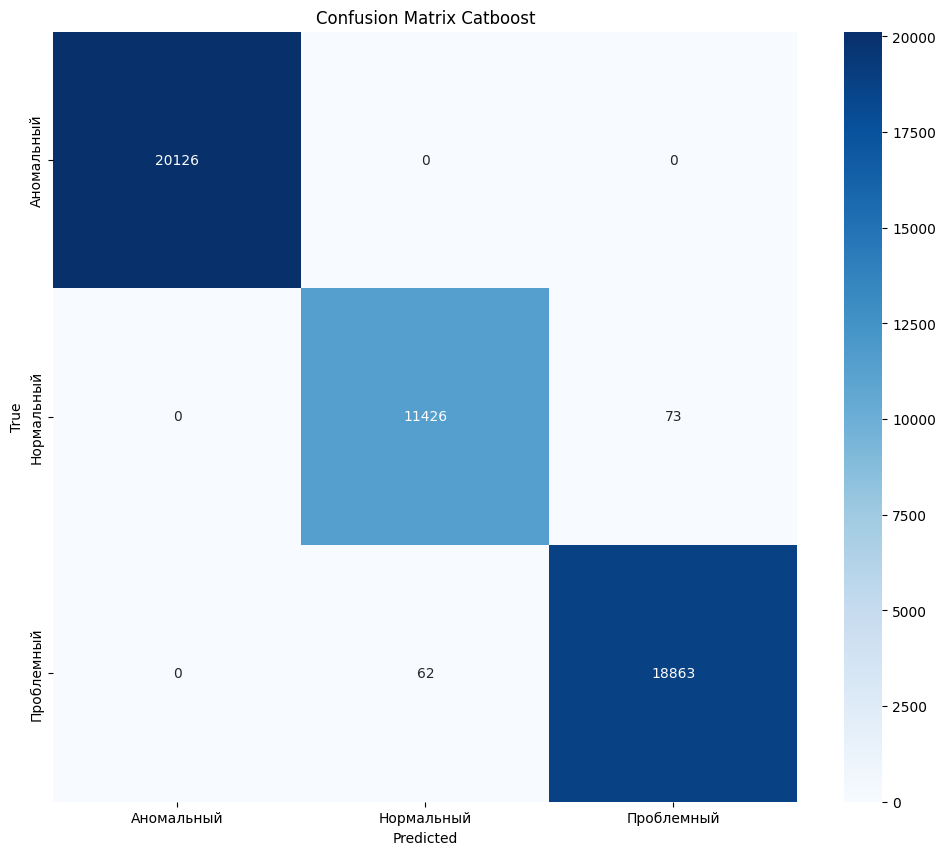

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Catboost")
plt.show()

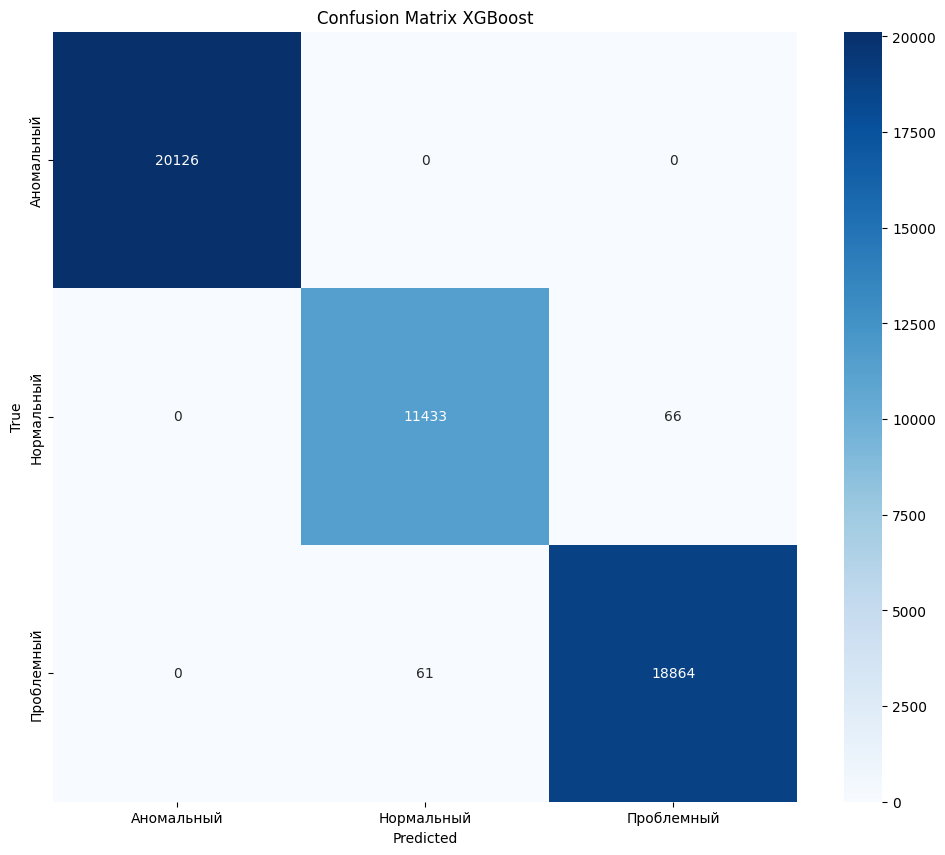

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix XGBoost")
plt.show()

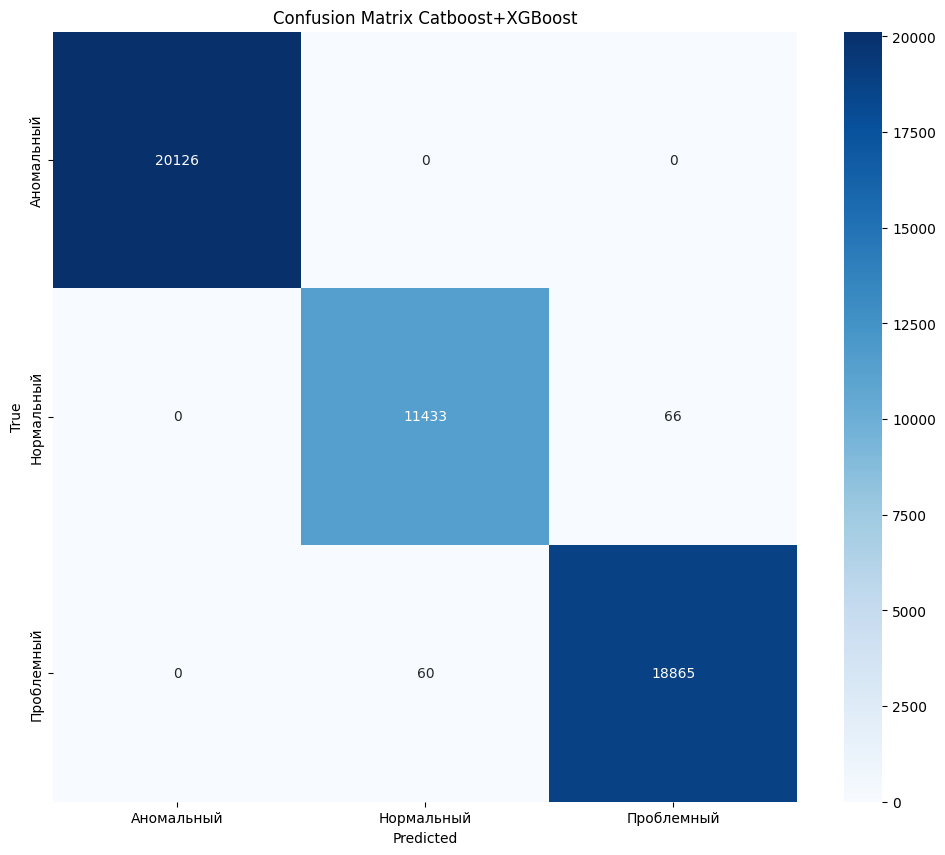

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_comb, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Catboost+XGBoost")
plt.show()

важность фичей для catboost

In [ ]:
feature_importances = catboost_model.get_feature_importance(prettified=True)
print(feature_importances)

                                           Feature Id  Importances
0                          Электросистема. Напряжение    14.407047
1               ДВС. Температура охлаждающей жидкости    13.144352
2                Значение счетчика моточасов, час:мин    11.825513
3                           Уровень топлива % (spn96)     9.557764
4              Давление в пневмостистеме (spn46), кПа     8.206906
5                КПП. Давление масла в системе смазки     7.618341
6                                Полож.пед.акселер.,%     6.599373
7                                ДВС. Давление смазки     6.341193
8                                   Обор.двиг.,об/мин     4.934403
9              ДВС. Частота вращения коленчатого вала     4.803798
10                                           Скорость     3.029415
11                                Темп.масла двиг.,°С     2.570660
12                             КПП. Температура масла     2.549405
13                               Давл.масла двиг.,кПа     2.51

In [ ]:
importances = catboost_model.get_feature_importance(type='PredictionValuesChange')#[:20]
feature_importances = pd.Series(importances, index=X_val.columns).sort_values().iloc[len(X_val.columns)-20:]

Text(0, 0.5, 'Features')

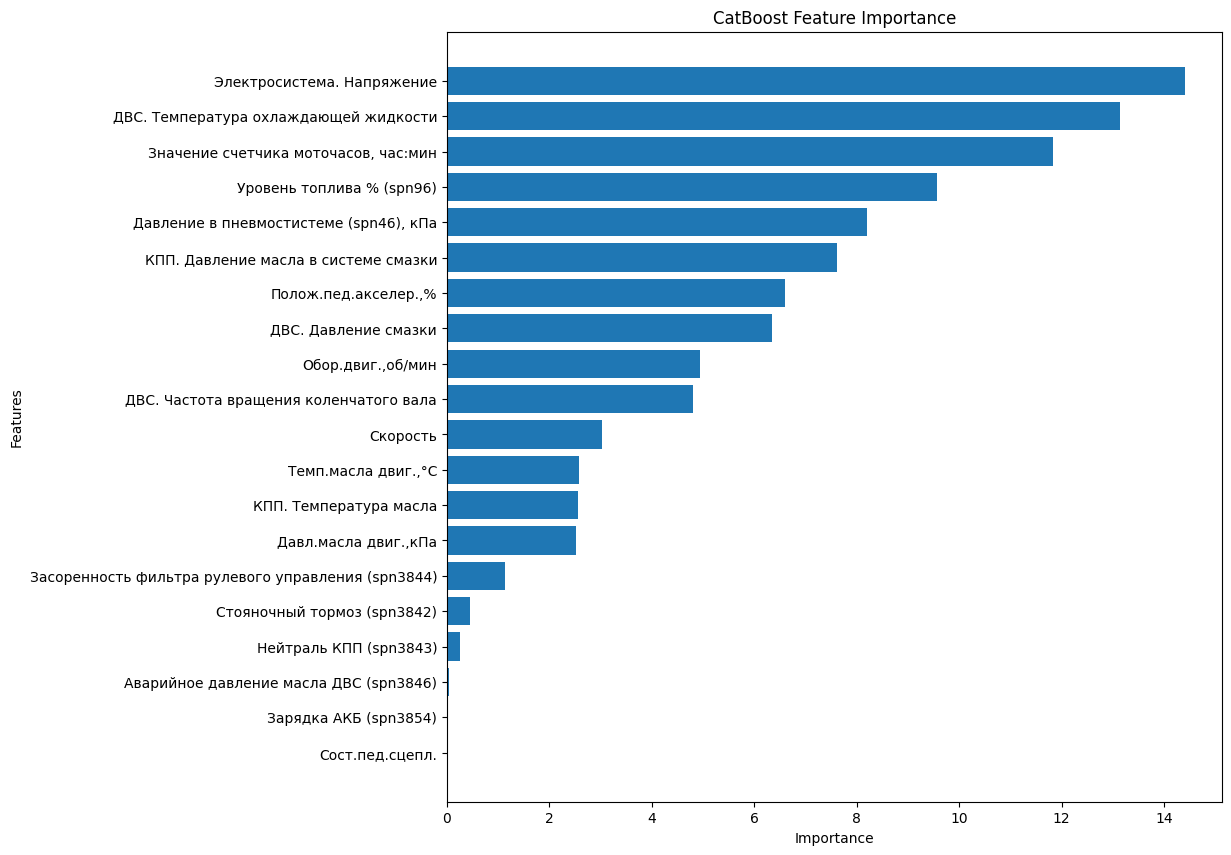

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

#Анализ важности фичей

Используем библиотеку для визуализации признаков

In [ ]:
mini_coef=10

X_val=X_val[:len(X_val)//mini_coef]
y_val=y_val[:len(y_val)//mini_coef]

In [ ]:
import shap

Для улучшения работы модели и более глубокого понимания исходных данных мы анализируем важность наших фичей, используя библиотеку shap, то есть расчитываем вклад каждой функции в итоговое предсказание модели. Для анализа используются графики force plot (график силы) и summary plot(итоговый график).

На графике силы красные полосы показывают, что их функции увеличивают значение до более высоких значений. Синие полосы показывают, что их особенности приводят к снижению ценности. Чем шире полоса, тем выше (по абсолютному значению) вклад. Сумма этих вкладов увеличивает значение целевой переменной до конечного, прогнозируемого значения.

На итоговом графике каждая точка каждой строки является записью тестового набора данных. Функции отсортированы от наиболее важных к менее важным. Цветом обозначены значения соответствующего признака: высокие – красным , низкие – синим.

In [ ]:
classes

array(['Аномальный', 'Нормальный', 'Проблемный'], dtype=object)

In [ ]:
name_of_class = 'Нормальный' #@param ['Аномальный', 'Нормальный', 'Проблемный']

#выборк на которой будем смотреть важность
pool = Pool(
    X_val, y_val, cat_features=cat_features
)

#расчет важности фичей
num_class=c2n[name_of_class]
explainer = shap.TreeExplainer(catboost_model)
shap_values=explainer.shap_values(pool)[:, :, num_class]
print(shap_values.shape)

(5055, 44)


Визуализация, называемая силовой график (force plot), которая помогает понять, как входные признаки влияют на предсказания модели.

Силовой график SHAP состоит из графика, в котором каждая стрелка представляет влияние одного конкретного признака на предсказание модели. В каждой стрелке отображается величина вклада этого признака в изменение предсказания от базового уровня (чаще всего среднего значения предсказания). Таким образом, силовой график помогает визуализировать влияние каждого признака на изменение предсказаний модели относительно базового уровня

In [ ]:
#пользователь для проверки
user=81

shap.initjs()
shap.force_plot(explainer.expected_value[num_class], shap_values[user,:], X_val.iloc[user,:])

In [ ]:
count_users = 441 #@param {type:"slider", min:0, max:40000, step:1}

#срез пользователей для проверки
shap.initjs()
X_small = X_val.iloc[:count_users]
shap_small = shap_values[:count_users]
shap.force_plot(explainer.expected_value[num_class], shap_small, X_small)


shap.summary_plot в библиотеке SHAP предназначен для визуализации обобщенного вклада признаков в модель машинного обучения. Этот график предоставляет общий обзор важности каждого признака в датасете.

Визуализация включает в себя вертикальные полосы, представляющие различные признаки, а горизонтальные полосы представляют вклад каждого признака для каждого наблюдения. Цвет каждой полосы указывает на значение признака (например, красный для более высоких значений, синий для более низких).

В shap.summary_plot, серые полосы представляют базовое значение (expected value) модели. Базовое значение представляет собой среднюю ожидаемую предсказанную целевую переменную на всем наборе данных. Такие полосы влияния (SHAP values) отображают вклад каждого признака в отклонение предсказания от базового уровня.

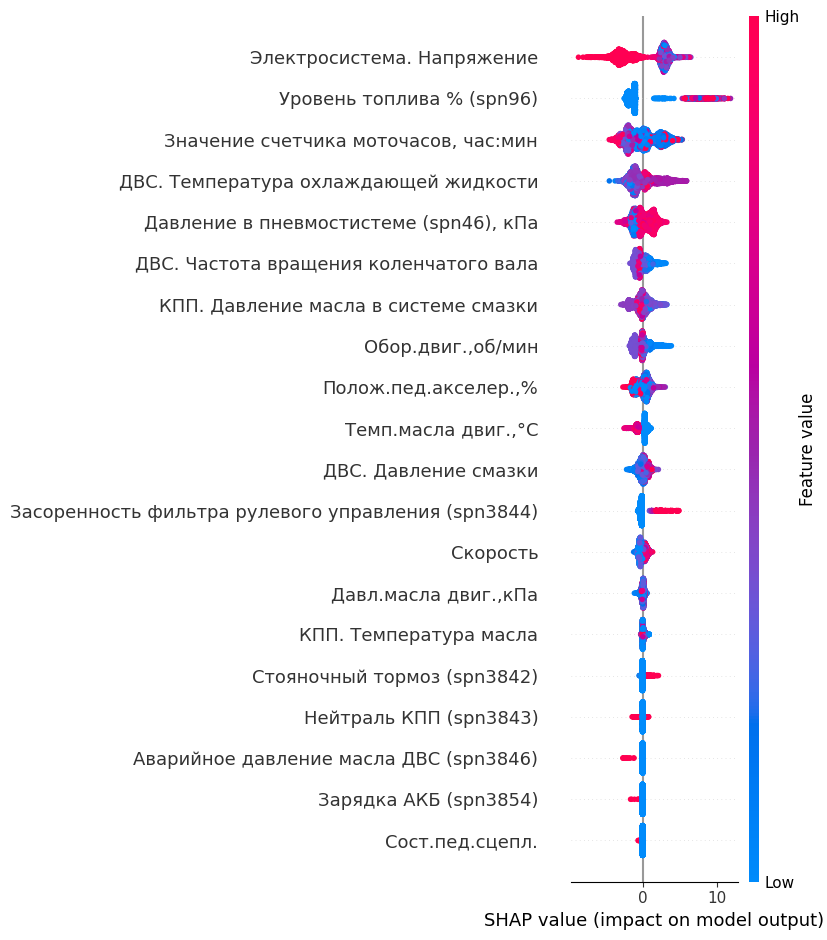

In [ ]:
shap.summary_plot(shap_values, X_val)

#Дополнительный функционал

##stage1

В этом блоге мы даем способность алгоритму распознавать какие именно системы трактора сломались на основе статистики и распределений

In [ ]:
#проверяет в какое распределение данных (Проблема, Нормально, Аномалия) входит каждый признак из подаваемого примера
def borders_check(sample,etalon_problem,etalon_normal,etalon_anomal):
  sample_check=pd.DataFrame({
      'mean': sample,
      'std': sample/95})

  data=pd.DataFrame()

  min_border_check=etalon_problem['range_min']>sample_check['mean']
  max_border_check=etalon_problem['range_max']<sample_check['mean']
  data['problem_border_check']=min_border_check+max_border_check

  min_border_check=etalon_normal['range_min']>sample_check['mean']
  max_border_check=etalon_normal['range_max']<sample_check['mean']
  data['normal_border_check']=min_border_check+max_border_check

  min_border_check=etalon_anomal['range_min']>sample_check['mean']
  max_border_check=etalon_anomal['range_max']<sample_check['mean']
  data['anomal_border_check']=min_border_check+max_border_check

  return data

In [ ]:
#эти две функции не используюся (Прототипы)
def percent_deviation(x, y):
    distance=abs(((x - y) / (x+y+1e-9)/2)) * 100
    return distance

def borders_check_v2(sample,etalon_problem,etalon_normal,etalon_anomal):
  sample_check=pd.DataFrame({
      'mean': sample,
      'std': sample/95})
  data=pd.DataFrame()
  temp = etalon_problem['range_min']>sample_check['mean']
  data['coef_border_problem']=temp*percent_deviation(etalon_problem['range_min'],sample_check['mean'])
  temp = etalon_problem['range_max']<sample_check['mean']
  data['coef_border_problem']= data['coef_border_problem'] + temp * percent_deviation(etalon_problem['range_max'],sample_check['mean'])

  temp = etalon_anomal['range_min']>sample_check['mean']
  data['coef_border_anomal']=temp*percent_deviation(etalon_anomal['range_min'],sample_check['mean'])
  temp = etalon_anomal['range_max']<sample_check['mean']
  data['coef_border_anomal']= data['coef_border_anomal'] + temp * percent_deviation(etalon_anomal['range_max'],sample_check['mean'])

  temp = etalon_normal['range_min']>sample_check['mean']
  data['coef_border_normal']=temp*percent_deviation(etalon_normal['range_min'],sample_check['mean'])
  temp = etalon_normal['range_max']<sample_check['mean']
  data['coef_border_normal']= data['coef_border_normal'] + temp * percent_deviation(etalon_normal['range_max'],sample_check['mean'])


  return data

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
from tqdm import tqdm

In [ ]:
#borders_check для многих экземпляров
def mass_borders_check(df,etalon_problem,etalon_normal,etalon_anomal):
  b_df=[]
  for index, row in tqdm(df.iterrows()):
    check_df=borders_check(row,etalon_problem,etalon_normal,etalon_anomal).T
    check_df['id']=[index]*len(check_df)
    b_df.append(check_df)

  b_dfs = pd.concat(b_df, axis=0)
  b_dfs=b_dfs.reset_index(drop=False)
  return b_dfs

In [ ]:
#Расчет наиболее часто встречающихся причин поломки в нашем логе
from collections import Counter
def find_most_popular(logs):
  class_counter = Counter(logs['predict'])
  most_common_class = class_counter.most_common(1)[0][0]

  item_counter = Counter(logs['break_parts'])
  most_common_item = item_counter.most_common(5)
  most_common_item = [x[0] for x in most_common_item]

  return {"most_common_class":most_common_class,"most_common_item":most_common_item}

In [ ]:
#Вызываются все фунции, прописанные в блоке stage 1
def stage1_predict(df_to_copy,catboost_model,XGBoost_model,etalon_problem,etalon_normal,etalon_anomal):
  df=df_to_copy.copy()
  y_pred = get_ansamble_predict(df,catboost_model,XGBoost_model)
  #y_pred = model.predict(df)
  df['label']=y_pred

  problem_df=df[df['label']=='Проблемный']
  problem_df=problem_df.drop(['label'], axis=1)
  if len(problem_df)>0:
    border_df=mass_borders_check(problem_df,etalon_problem,etalon_normal,etalon_anomal)
  else: border_df=pd.DataFrame({'index':[np.NaN],'id':[np.NaN]})

  mean_log={'predict':[],'break_parts':[]}
  logs={}
  for index, row in df.iterrows():
    log={}
    log['predict']=row['label']
    mean_log['predict'].append(row['label'])

    mini_b_df=border_df[border_df['id']==index]
    n_mini_b_df=mini_b_df[mini_b_df['index']=='problem_border_check']

    columns_with_value = n_mini_b_df.columns[n_mini_b_df.isin([False]).any()].tolist()
    log['break_parts']= columns_with_value
    mean_log['break_parts'].extend(columns_with_value)

    logs[index]=log

  return mean_log

##stage2

На этом этапе даем возможность предсказывать алгоритму сломается ли скоро трактор/возникнут ли аномалии

In [ ]:
collection = create_db(df)
#from chromadb.collections import Collection


In [ ]:


def pred_future(collection, data):
  #df=df.drop(['label'], axis=1)
  jj=get_simularity_samples(collection,data)
  try:
    jj=[x[0]['label'] for x in jj['metadatas']]
    data['mb_future']=jj
  except:
    data['mb_future']=[0] * len(data)
  return data

#pred_future(collection, df.iloc[:1000])

In [ ]:
def stage2(logs, data, collection):
  data = pred_future(collection, data)
  #for index, row in data.iterrows():
  #  logs[index]['mb_future']=row['mb_future']
  logs['mb_future']=data['mb_future'].mode()[0]
  return logs

#Обработка логов

Эта часть используется для быстрого запуска всего алгоритма (это часть продублирована в dgango так что тут ее нет смысла запускать)

In [ ]:
client = chromadb.PersistentClient('/content/chroma')
collection = client.create_collection("all-my-documents")

In [ ]:
list_to_drop=['Дата и время', 'Нагрузка на двигатель, %', 'iButton2', 'Крутящий момент (spn513), Нм',
'Положение рейки ТНВД (spn51), %', 'Расход топлива (spn183), л/ч',
'ДВС. Температура наддувочного воздуха, °С',
'Давление наддувочного воздуха двигателя (spn106), кПа', 'Текущая передача (spn523)',
'Температура масла гидравлики (spn5536), С', 'Педаль слива (spn598)']

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os

In [ ]:
path_to_catboost_model="/content/catboost_model.bin"
from catboost import CatBoostClassifier
import pandas as pd
catboost_model = CatBoostClassifier()
catboost_model.load_model(path_to_catboost_model)

path_to_XGBoost_model="/content/catboost_model.bin"
XGBoost_model = CatBoostClassifier()
XGBoost_model.load_model(path_to_XGBoost_model)

In [ ]:
zip_file_path="/content/drive/MyDrive/хаки/EES/logs.zip"

In [ ]:


def model_predict(model, data):
  predicts = model.predict(data)
  return predicts

In [ ]:
def read_mini_logs(mini_logs,dir_path):
  dfs = []

  # Прочитать каждый файл в DataFrame и добавить его в список
  for file in mini_logs:
      if file.endswith('.csv'):  # Предполагаем, что файлы в формате CSV
          path = os.path.join(dir_path, file)
          df = pd.read_csv(path, sep=";")
          dfs.append(df)

  # Объединить DataFrame в один общий DataFrame
  merged_df = pd.concat(dfs, ignore_index=True, axis=0)

  return merged_df

In [ ]:
def analise_logs(zip_file_path,unzip_dir_path,catboost_model,XGBoost_model,list_to_drop,collection,etalon_problem,etalon_normal,etalon_anomal):

  # Распаковываем архив
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(unzip_dir_path)

  unzip_dir_path+='/logs'
  predicts_logs={}

  # Получаем список всех папок в распакованной директории
  folders = [name for name in os.listdir(unzip_dir_path) if os.path.isdir(os.path.join(unzip_dir_path, name))]
  for folder in folders:
    dir_path=f"{unzip_dir_path}/{folder}"
    mini_logs=folders = os.listdir(dir_path)

    #data = pd.read_csv(f"{path}/{mini_logs[0]}", sep=";")
    data=read_mini_logs(mini_logs,dir_path)

    data = data_preprocess(data,list_to_drop, mode='Test')
    logs=stage1_predict(data,catboost_model,XGBoost_model,etalon_problem,etalon_normal,etalon_anomal)

    logs= find_most_popular(logs)
    logs=stage2(logs, data, collection)

    predicts_logs[folder]=logs


  return predicts_logs



In [ ]:
etalon_problem=pd.read_csv("etalon_problem.csv")
etalon_normal=pd.read_csv("etalon_normal.csv")
etalon_anomal=pd.read_csv("etalon_anomal.csv")
etalon_problem=etalon_problem.rename(columns={'Unnamed: 0':''}).set_index('')
etalon_normal=etalon_normal.rename(columns={'Unnamed: 0':''}).set_index('')
etalon_anomal=etalon_anomal.rename(columns={'Unnamed: 0':''}).set_index('')

In [ ]:
#не успели перезапустить, все должно работать

In [ ]:
predicts_logs = analise_logs(zip_file_path, './unzip1', catboost_model,XGBoost_model,list_to_drop,collection,etalon_problem,etalon_normal,etalon_anomal)

Предобработка начата


2it [00:00, 211.73it/s]


IndexError: list index out of range

In [ ]:
predicts_logs